In [2]:
#Installing Necessary Libraries
!pip install wandb
!pip install pytorch_lightning

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Import Neccessary Libraries
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from pytorch_lightning.loggers import WandbLogger

In [5]:
# Login to wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
#Define CNN_Model
class CNN(pl.LightningModule):
    def __init__(self, input_shape, num_classes, num_filters=32, filter_size=(3, 3), activation='relu',
                 dense_neurons=128, dropout_rate=0.2, data_augmentation=False, batch_norm=True):
        super().__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.activation = activation
        self.dense_neurons = dense_neurons
        self.dropout_rate = dropout_rate
        self.data_augmentation = data_augmentation
        self.batch_norm = batch_norm

        self.conv_layers = self._create_conv_layers()
        self.dense_layers = self._create_dense_layers()

    def _create_conv_layers(self):
        layers = []
        in_channels = self.input_shape[0]
        for out_channels in [self.num_filters, self.num_filters, self.num_filters, self.num_filters, self.num_filters]:
            layers.append(nn.Conv2d(in_channels, out_channels, self.filter_size, padding='same'))
            if self.batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(self.get_activation())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def _create_dense_layers(self):
        layers = [
            nn.Flatten(),
            nn.Linear(self.conv_output_size(), self.dense_neurons),
            self.get_activation(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.dense_neurons, self.num_classes)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.dense_layers(x)
        return x

    def get_activation(self):
      if self.activation == 'relu':
        return nn.ReLU()
      elif self.activation == 'gelu':
        return nn.GELU()
      elif self.activation == 'silu':
        return nn.SiLU()
      elif self.activation == 'mish':
        return nn.Mish()
      else:
        raise ValueError("Invalid activation function specified.")

    def conv_output_size(self):
        dummy_input = torch.zeros(1, *self.input_shape)
        dummy_output = self.conv_layers(dummy_input)
        return dummy_output.flatten(1).size(-1)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        accuracy = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        accuracy = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [7]:
#Import Libraries
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the paths to the training and validation directories
train_dir = '/content/drive/MyDrive/inaturalist_12K/train'
val_dir = '/content/drive/MyDrive/inaturalist_12K/val'

# Create the training and validation datasets
train_dataset = ImageFolder(train_dir, transform=transform)
val_dataset = ImageFolder(val_dir, transform=transform)

# Create the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Define Sweep Configuration
sweep_config = {
    'method': 'random',  # Specify the search method
    'parameters': {
        'num_filters': {'values': [32, 64, 128]},
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'data_augmentation': {'values': [True, False]},
        'batch_norm': {'values': [True, False]},
        'dropout': {'values': [0.2, 0.3]}
    }
}

# Create WandB sweep
sweep_id = wandb.sweep(sweep=sweep_config, project="DL_Assignment_2")

# Import WandB logger
from pytorch_lightning.loggers import WandbLogger

# Initialize WandB logger
wandb_logger = WandbLogger()

def train_model():
    # Initialize WandB run
    with wandb.init() as run:
        # Set the name of the run
        run_name = f"num_filters_{wandb.config.num_filters}_activation_{wandb.config.activation}_data_augmentation_{wandb.config.data_augmentation}_batch_norm_{wandb.config.batch_norm}_dropout_{wandb.config.dropout}"
        wandb.run.name = run_name
        config = wandb.config

        # Define data transformations
        data_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Create the training and validation datasets
        train_dataset = ImageFolder(train_dir, transform=data_transforms)
        val_dataset = ImageFolder(val_dir, transform=data_transforms)

        # Create the data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

        # Initialize model
        input_shape = (3, 224, 224)
        num_classes = len(train_dataset.classes)
        model = CNN(input_shape, num_classes,
                    activation=config.activation,
                    data_augmentation=config.data_augmentation,
                    batch_norm=config.batch_norm,
                    dropout_rate=config.dropout)

        # Define trainer
        trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)

        # Train the model
        trainer.fit(model, train_loader, val_loader)

# Start the sweep
wandb.agent(sweep_id, function=train_model, count=50)


Create sweep with ID: rw9fmfoh
Sweep URL: https://wandb.ai/kartik12/DL_Assignment_2/sweeps/rw9fmfoh


wandb: Agent Starting Run: rx2mw0lc with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	data_augmentation: True
wandb: 	dropout: 0.2
wandb: 	num_filters: 128
wandb: Currently logged in as: ramankartik12 (kartik12). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | conv_layers  | Sequential | 38.2 K
1 | dense_layers | Sequential | 202 K 
--------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Validation: |          | 0/? [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


In [10]:
# Import necessary libraries
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np

# Define the path to the test directory
test_dir = '/content/drive/MyDrive/inaturalist_12K/val'

# Define data transformations for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the test dataset
test_dataset = ImageFolder(test_dir, transform=test_transform)

# Create the data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define the input shape and number of classes
input_shape = (3, 224, 224)  # Assuming input images are RGB with size 224x224
num_classes = len(test_dataset.classes)  # Get the number of classes from the test dataset

# Initialize the CNN model with the specified input shape and number of classes
model = CNN(input_shape=input_shape, num_classes=num_classes)



# Load the best model checkpoint and provide input_shape and num_classes arguments
best_model_path = '/content/DL_Assignment_2/rx2mw0lc/checkpoints/epoch=6-step=2191.ckpt'  # Specify the path to the best model checkpoint
best_model = CNN.load_from_checkpoint(best_model_path, input_shape=input_shape, num_classes=num_classes)

# Set the model to evaluation mode
best_model.eval()

# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store predictions and ground truth labels
predictions = []
labels = []

# Iterate over the test dataset and make predictions
for images, targets in test_loader:
    with torch.no_grad():
        outputs = best_model(images)
        predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Calculate accuracy on the test set
correct = np.sum(np.array(predictions) == np.array(labels))
total = len(predictions)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.2f}')





Test Accuracy: 0.34


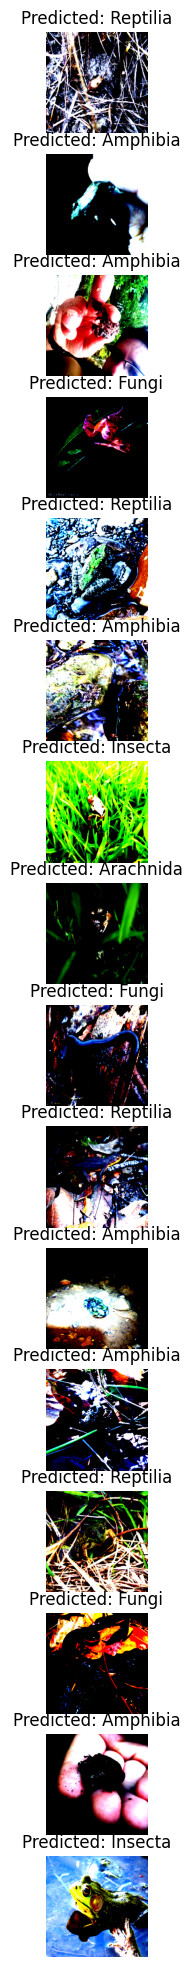

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images with their predictions
def display_images(images, predictions, classes, num_rows=10, num_cols=3):
    plt.figure(figsize=(15, 25))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        image = np.transpose(images[i], (1, 2, 0))  # Transpose the image data to (height, width, channels)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Predicted: {classes[predictions[i]]}')



# Define the classes for your dataset
classes = test_dataset.classes

# Get a batch of sample images from the test loader
sample_batch = next(iter(test_loader))
sample_images, sample_labels = sample_batch

# Display the images with their predictions
display_images(sample_images, predictions, classes, num_rows=sample_images.shape[0], num_cols=1)
plt.show()
